In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cantera as ct
import concurrent.futures

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
butane_yaml = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126/chem_annotated.yaml'
# butane_yaml = '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423/chem_annotated.yaml'

In [2]:
# Load the experimental conditions
# ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
ignition_delay_data = '/home/harris.se/peng_2021.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 1]
# Define Initial conditions using experimental data
tau7 = table7['time (us)'].values.astype(float) / 1000.0# ignition delay
T7 = table7['T_i (K)'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://www-sciencedirect-com.ezproxy.neu.edu/science/article/pii/S0010218021003898?via%3Dihub
concentrations = []


# for phi = 1


x_diluent = table7['%CO2'].values.astype(float)[0]
phi = table7['phi'].values.astype(float)[0]

x_o2 = (1.0 - x_diluent) / (1.0 + 2 / 13.0 * phi)
x_butane = 1.0 - x_diluent - x_o2


conc_dict = {
    'O2(2)': x_o2,
    'butane(1)': x_butane,
    'CO2(7)' : x_diluent
}

for i in range(0, len(table7)):
    concentrations.append(conc_dict)



In [4]:
P7

array([101325., 101325., 101325., 101325., 101325.])

In [5]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T_orig, P_orig, X_orig):
    # function to run a RCM simulation
    
    atols = [1e-15, 1e-15, 1e-18]
    rtols = [1e-9, 1e-12, 1e-15]
    for attempt_index in range(0, len(atols)):
        T = T_orig
        P = P_orig
        X = X_orig
    

        t_end = 1.0  # time in seconds
        gas.TPX = T, P, X

        env = ct.Reservoir(ct.Solution('air.yaml'))
        reactor = ct.IdealGasReactor(gas)
        wall = ct.Wall(reactor, env, A=1.0, velocity=0)
        reactor_net = ct.ReactorNet([reactor])
        reactor_net.atol = atols[attempt_index]
        reactor_net.rtol = rtols[attempt_index]

        times = [0]
        T = [reactor.T]
        P = [reactor.thermo.P]
        X = [reactor.thermo.X]  # mol fractions
        
        MAX_STEPS = 10000
        step_count = 0
        failed = False
        while reactor_net.time < t_end:
            try:
                reactor_net.step()
            except ct._cantera.CanteraError:
                print(f'Reactor failed to solve! {attempt_index}')
                failed = True
                break

            times.append(reactor_net.time)
            T.append(reactor.T)
            P.append(reactor.thermo.P)
            X.append(reactor.thermo.X)

            step_count += 1
            if step_count > MAX_STEPS:
                print(f'Too many steps! Reactor failed to solve! {attempt_index}')
                # print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                failed = True
                break
        
        if not failed:
            slopes = np.gradient(P, times)
            delay_i = np.argmax(slopes)
            return times[delay_i]
        return -1
        
#         slopes = np.gradient(P, times)
#         i = np.argmax(slopes)
#         return times[i]

In [6]:
def run_simulation(condition_index):
    gas = ct.Solution(butane_yaml)
    X = concentrations[condition_index]
    delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
    print(f'Completed {condition_index}:\t {delay}')
    return delay

In [ ]:
# Run all simulations in parallel
delays = np.zeros(len(table7))
condition_indices = np.arange(0, len(table7))
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(run_simulation, condition_indices)):
        delays[condition_index] = delay_time

In [ ]:
delays

In [ ]:
iter0 = np.array([0.00099921, 0.00017139, 0.00030184, 0.00039824, 0.00066331])
iter5 = np.array([0.00080206, 0.00012514, 0.00021517, 0.00028614, 0.00049938])

In [ ]:
# plot the ignition delay
# plt.plot(1000.0 / T7, full_base_rmg7, marker='x', label='large_seed_1week')
# plt.plot(1000.0 / T7, aramco7, marker='x', label='aramco')
plt.scatter(1000.0 / T7, iter0, marker='o', label='Run 0')
# plt.plot(1000.0 / T7, iter1, marker='o', label='Run 1')
# plt.plot(1000.0 / T7, iter2, marker='o', label='Run 2')
# plt.plot(1000.0 / T7, iter3, marker='o', label='Run 3')
# plt.plot(1000.0 / T7, iter4, marker='o', label='Run 4')
plt.scatter(1000.0 / T7, iter5, marker='o', label='Run 5')
# plt.plot(1000.0 / T7, iter3p2, marker='o', label='Run 3.2')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
plt.legend(bbox_to_anchor=(1, 1))

# plot all the peng data


In [3]:
model_dirs = glob.glob('/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_*')

In [4]:
model_dirs

['/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240126',
 '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240315',
 '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240403',
 '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240410',
 '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240416',
 '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240423',
 '/work/westgroup/harris.se/autoscience/fuels/butane/official/butane_20240501']

In [5]:
table7

,Table,%N2,%Ar,%CO2,partial pressure / bar,T_i (K),CR?,chamber pressure? (bar),T_C,time (us),phi,nominal pressure(atm),Unnamed: 12,Unnamed: 13,Unnamed: 14
0,1.0,0.0,0.0,0.77385,NaN,1296.1,NaN,NaN,NaN,724.96552,0.5,1.0,NaN,NaN,NaN
1,1.0,0.0,0.0,0.77385,NaN,1416.9,NaN,NaN,NaN,88.00000,0.5,1.0,NaN,NaN,NaN
2,1.0,0.0,0.0,0.77385,NaN,1377.1,NaN,NaN,NaN,157.00000,0.5,1.0,NaN,NaN,NaN
3,1.0,0.0,0.0,0.77385,NaN,1358.0,NaN,NaN,NaN,209.00000,0.5,1.0,NaN,NaN,NaN
4,1.0,0.0,0.0,0.77385,NaN,1323.4,NaN,NaN,NaN,295.00000,0.5,1.0,NaN,NaN,NaN


11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
Name: phi, dtype: float64


Text(0, 0.5, 'Delay (s)')

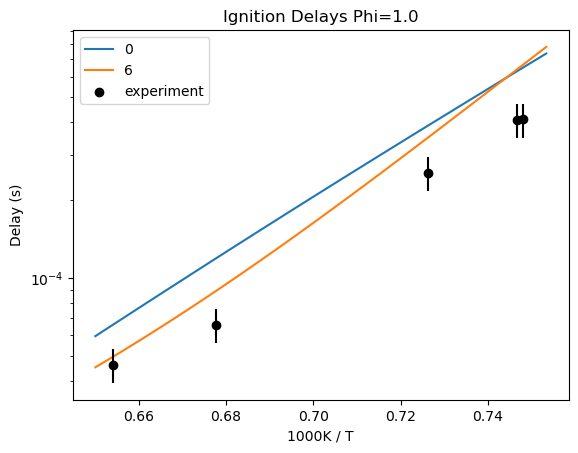

In [26]:
ignition_delay_data = '/home/harris.se/peng_2021.csv'
df_exp = pd.read_csv(ignition_delay_data)

table_index = 3


table7 = df_exp[df_exp['Table'] == table_index]
tau7 = table7['time (us)'].values.astype(float) / 1000.0  # ignition delay
T7 = table7['T_i (K)'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm
print(table7['phi'])

# for model_index in range(len(model_dirs)):
for model_index in [0, 6]:
    npy_file = os.path.join(model_dirs[model_index], 'peng_2021', f'table_{table_index}.npy')
    data = np.load(npy_file)
    temperatures = data[0, :]
    delays = data[1, :]
    
    # plot the ignition delay
    plt.plot(1000.0 / temperatures, delays, label=model_index)

# get that table's experimental data
# says 15% error on ignition delay
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')

for e in range(len(tau7)):
    plt.errorbar(1000.0 / T7[e], tau7[e] / 1000.0, yerr=tau7[e] / 1000.0 * 0.15, color='black')


ax = plt.gca()
ax.set_yscale('log')
plt.legend()
plt.title(f'Ignition Delays Phi={table7["phi"].values[table_index]}')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
# plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(1, 1))



In [ ]:
temperatures